In [1]:
import os
import uproot
import pandas as pd
import awkward as ak
import math
import os
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import nbformat
import sklearn.metrics as metrics
from itertools import combinations
print(nbformat.__version__)

5.10.4


In [2]:
WEBSITE = '/web/gbrodbek/public_html'

In [3]:
df = pd.read_pickle("run3_newdatalabels/testruns/modelsaves/model_output_eval_logits.pt")
df.keys()

Index(['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0', 'background',
       'labels_true', 'energy'],
      dtype='object')

## One-vs-rest ROC curves

AUC for e: 0.9973050449402885
AUC for mu: 0.9991102274747249
AUC for pi_pi0: 0.9657673067050715
AUC for pi: 0.9846712669129662
AUC for pi_2pi0: 0.9450932201797051
AUC for 3pi: 0.9849235950547104
AUC for 3pi_pi0: 0.9629754812768667


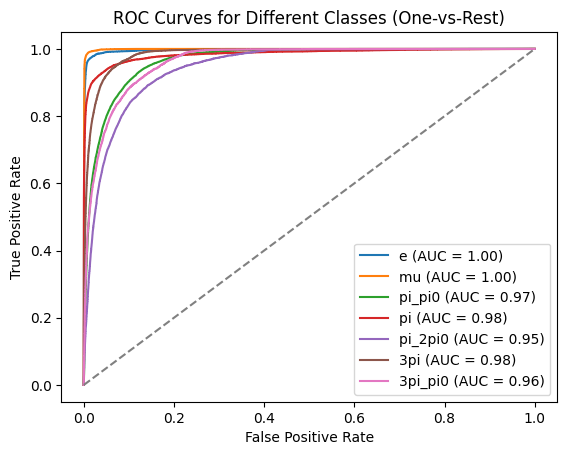

In [10]:
probs_columns = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']
labels = df['labels_true']
fpr_list, tpr_list, auc_list = [], [], []

# Iterate over each probability column and treat it as a binary classification (one-vs-rest)
for i, prob_col in enumerate(probs_columns):
    probs = df[prob_col]  # Probabilities for the current class
    fpr, tpr, thresholds = metrics.roc_curve(labels, probs, pos_label=i)  # pos_label=i for binary ROC curve
    auc = metrics.auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    
    print(f"AUC for {prob_col}: {auc}")

# Plot ROC curves for each class
# plt.figure(figsize=(10, 6))
for fpr, tpr, auc, prob_col in zip(fpr_list, tpr_list, auc_list, probs_columns):
    plt.plot(fpr, tpr, label=f"{prob_col} (AUC = {auc:.2f})")
    
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classes (One-vs-Rest)")
plt.legend(loc="lower right")
# plt.savefig(os.path.join(WEBSITE, 'ROC_curves' ,'ROC_all_vs_rest.png'))
plt.show()

## One-vs-one ROC curves:

AUC for 3pi_pi0: 0.8350141049365182


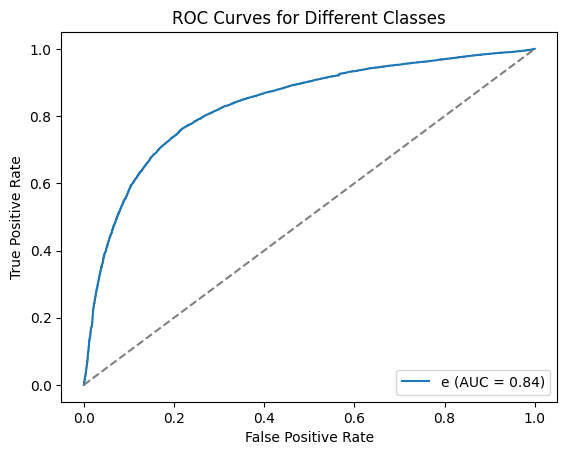

In [5]:
# filter only events from e and mu classes
filter = (df.labels_true == 2) | (df.labels_true == 4)
df_filtered = df[filter]
labels_filtered = df_filtered['labels_true']


probs = df_filtered['pi_pi0']  # Probabilities for the current class
fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, probs, pos_label=2)  # pos_label=i for binary ROC curve
auc = metrics.auc(fpr, tpr)
print(f"AUC for {prob_col}: {auc}")

plt.plot(fpr, tpr, label=f"e (AUC = {auc:.2f})")
    
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Classes")
plt.legend(loc="lower right")
plt.show()

In [6]:
def plot_ROC(df, decayclass, save_path=None, figshow=True):
    decays = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']   # check if valid decay mode is given
    if decayclass not in decays:
        print("Invalid decay mode, please choose from: ", decays)
        return
    index_decay = decays.index(decayclass)          # find index of decay mode

    # plot the ROC curve against all other classes
    fpr, tpr, thresholds = metrics.roc_curve(df['labels_true'], df[decayclass], pos_label=index_decay)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"all (AUC = {auc:.2f})")
    
    # iterate over all other classes and plot the ROC curve against them
    for i, decay in enumerate(decays):
        if decay == decayclass:    # skip the decay mode itself
            continue
        filter = (df.labels_true == index_decay) | (df.labels_true == i)        # filter only events from the two classes
        labels_filtered = df[filter]['labels_true']
        scores = df[filter][decayclass]
        fpr, tpr, thresholds = metrics.roc_curve(labels_filtered, scores, pos_label=index_decay)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{decay} (AUC = {auc:.2f})")

    plt.title(f"ROC Curves for {decayclass} against the other Classes")    
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    
    if save_path: plt.savefig(save_path)
    plt.show() if figshow else plt.close()
    

In [7]:
# save them all to the webpage
decays = ['e', 'mu', 'pi_pi0', 'pi', 'pi_2pi0', '3pi', '3pi_pi0']
for decay in decays:
    save_path = os.path.join(WEBSITE, 'ROC_curves', f"ROC_{decay}.png")
    plot_ROC(df, decay, save_path=save_path, figshow=False)

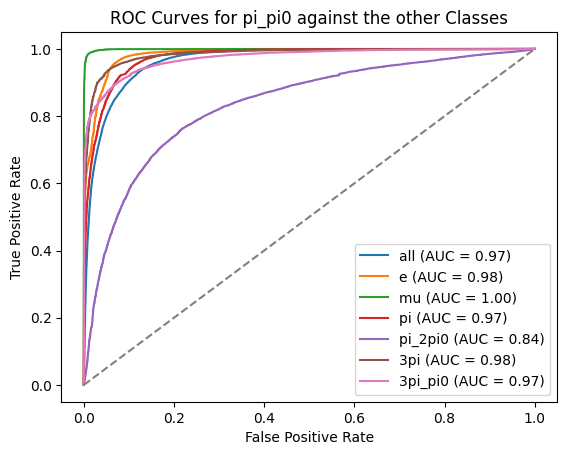

In [12]:
plot_ROC(df, 'pi_pi0')